# A computationally efficient nonparametric approach for changepoint detection
# https://arxiv.org/abs/1602.01254 

In [1]:
import numpy as np

In [2]:
def generate_synthetic_data(changepoints, segment_means, length=1000):
    data = []
    start = 0
    for cp, mean in zip(changepoints, segment_means):
        segment = np.random.normal(loc=mean, scale=1, size=cp - start)
        data.extend(segment)
        start = cp
    data.extend(np.random.normal(loc=segment_means[-1], scale=1, size=length - start))
    return np.array(data)

def normalize(data):
    return (data - np.mean(data)) / np.std(data)

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')



In [3]:
# Or generate synthetic data
data = generate_synthetic_data(changepoints=[200, 400, 600], segment_means=[5, 10, 5, 0])

# Normalize the data
normalized_data = normalize(data)

# Apply smoothing
smoothed_data = moving_average(normalized_data, window_size=5)

In [4]:
def log_likelihood(segment):
    n = len(segment)
    mean = np.mean(segment)
    variance = np.var(segment)
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(variance) - 0.5 * np.sum((segment - mean) ** 2) / variance
    return log_likelihood


def penalized_cost(segment, penalty_factor=1):
    n = len(segment)
    p = 2  # Number of parameters for Gaussian distribution
    penalty = penalty_factor * (p / 2) * np.log(n)
    cost = -log_likelihood(segment) + penalty
    return cost

In [37]:
def initialize_pelt(data_length, penalty_factor):
    costs = [0] * (data_length + 1)  # Costs for each segmentation point
    segments = [0] * (data_length + 1)  # Segment starting points
    candidates = [0]  # Candidate changepoints
    return costs, segments, candidates


def pelt_algorithm(data, penalty_factor=1):
    data_length = len(data)
    costs, segments, candidates = initialize_pelt(data_length, penalty_factor)

    for t in range(1, data_length + 1):
        min_cost = float('inf')
        min_candidate = 0

        # Iterate through candidate changepoints and find the one that minimizes the cost
        for candidate in candidates:
            segment = data[candidate:t]
            cost = penalized_cost(segment, penalty_factor) + costs[candidate]
            if cost < min_cost:
                min_cost = cost
                min_candidate = candidate

        costs[t] = min_cost
        segments[t] = min_candidate

        # Update candidates based on pruning strategy
        candidates = pruning_strategy(candidates, costs, t)

    return extract_changepoints(segments, costs)


# def pelt_algorithm(data, penalty_factor=1):
#     data_length = len(data)
#     costs, segments, candidates = initialize_pelt(data_length, penalty_factor)

#     for t in range(1, data_length + 1):
#         min_cost = float('inf')
#         min_candidate = 0
#         current_candidates = list(range(t))  # Define candidates up to current time t

#         # Iterate through candidate changepoints and find the one that minimizes the cost
#         for candidate in current_candidates:
#             segment = data[candidate:t]
#             cost = penalized_cost(segment, penalty_factor) + costs[candidate]
#             if cost < min_cost:
#                 min_cost = cost
#                 min_candidate = candidate

#         costs[t] = min_cost
#         segments[t] = min_candidate

#         # Update candidates based on pruning strategy
#         candidates = pruning_strategy(current_candidates, costs, t, data, penalty_factor)


#     return extract_changepoints(segments, costs)



def extract_changepoints(segments, costs):
    changepoints = []
    t = len(segments) - 1
    while t > 0:
        changepoint = segments[t]
        changepoints.append(changepoint)
        t = changepoint
    return sorted(changepoints)


# def extract_changepoints(segments, costs):
#     changepoints = []
#     t = len(segments) - 1
#     while t > 0:
#         changepoint = segments[t]
#         changepoints.append(changepoint)
#         t = changepoint
#         segments[t] = 0  # Setting the segment at this changepoint to 0 to avoid looping back to the same point
#     return sorted(changepoints)



In [29]:
def pruning_strategy(candidates, costs, t):
    pruned_candidates = [0]  # Always keep the first candidate (start of the data)

    # Iterate through the candidates in reverse order
    for i in reversed(candidates[1:]):
        # If the cost of candidate i is less than the cost of the last pruned candidate,
        # add it to the pruned candidates
        if costs[i] < costs[pruned_candidates[-1]]:
            pruned_candidates.append(i)

    return pruned_candidates[::-1]  # Return the pruned candidates in ascending order


# def pruning_strategy(candidates, costs, t):
#     pruned_candidates = []
    
#     for i in range(len(candidates) - 1, -1, -1):
#         candidate = candidates[i]
#         if i == len(candidates) - 1 or costs[candidate] + penalized_cost(data[candidate:t]) < costs[pruned_candidates[-1]] + penalized_cost(data[pruned_candidates[-1]:t]):
#             pruned_candidates.append(candidate)

#     return pruned_candidates[::-1]  # Return the pruned candidates in ascending order



# def pruning_strategy(candidates, costs, t, data, penalty_factor):
#     pruned_candidates = candidates.copy()
    
#     # Simple pruning logic
#     for i in reversed(range(len(candidates) - 1)):
#         segment1 = data[candidates[i]:t]
#         segment2 = data[candidates[i+1]:t]
#         cost1 = penalized_cost(segment1, penalty_factor)
#         cost2 = penalized_cost(segment2, penalty_factor)
        
#         if cost1 > cost2:
#             pruned_candidates.remove(candidates[i])
            
#     return pruned_candidates


In [30]:
def define_penalty_range(start, end, step):
    return np.arange(start, end, step)


def apply_pelt_with_crops(data, penalty_range):
    all_changepoints = {}
    for penalty in penalty_range:
        changepoints = pelt_algorithm(data, penalty_factor=penalty)
        all_changepoints[penalty] = changepoints
    return all_changepoints


In [31]:
# Define the range of penalties
penalty_range = define_penalty_range(start=1, end=10, step=0.5)

# Apply PELT with CROPS
all_changepoints = apply_pelt_with_crops(data, penalty_range)




/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_60753/2947813011.py:5: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(variance) - 0.5 * np.sum((segment - mean) ** 2) / variance
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_60753/2947813011.py:5: RuntimeWarning: invalid value encountered in scalar divide
  log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(variance) - 0.5 * np.sum((segment - mean) ** 2) / variance


KeyboardInterrupt: 

In [40]:
penalty_factor = 5
changepoints = pelt_algorithm(data, penalty_factor=penalty_factor)



/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_60753/2947813011.py:5: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(variance) - 0.5 * np.sum((segment - mean) ** 2) / variance
/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_60753/2947813011.py:5: RuntimeWarning: invalid value encountered in scalar divide
  log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(variance) - 0.5 * np.sum((segment - mean) ** 2) / variance


t: 1, min_cost: inf, min_candidate: 0, candidates: [0]
t: 2, min_cost: 5.658145452720006, min_candidate: 0, candidates: [0, 1]
t: 3, min_cost: 8.173953819923163, min_candidate: 0, candidates: [1, 2]
t: 4, min_cost: 9.007768597669648, min_candidate: 2, candidates: [2, 3]
t: 5, min_cost: 14.21507476838196, min_candidate: 3, candidates: [3, 4]
t: 6, min_cost: 14.37745965528084, min_candidate: 4, candidates: [4, 5]
t: 7, min_cost: 16.80429330944959, min_candidate: 4, candidates: [5, 6]
t: 8, min_cost: 20.022613235402062, min_candidate: 6, candidates: [6, 7]
t: 9, min_cost: 22.05413439816048, min_candidate: 4, candidates: [7, 8]
t: 10, min_cost: 24.025311764357095, min_candidate: 0, candidates: [8, 9]
t: 11, min_cost: 25.417475682907202, min_candidate: 0, candidates: [9, 10]
t: 12, min_cost: 26.903374169196326, min_candidate: 0, candidates: [10, 11]
t: 13, min_cost: 28.0187381155864, min_candidate: 0, candidates: [11, 12]
t: 14, min_cost: 33.382803940318276, min_candidate: 0, candidates: [1

t: 124, min_cost: 206.87369386209053, min_candidate: 0, candidates: [122, 123]
t: 125, min_cost: 207.7932283274131, min_candidate: 123, candidates: [123, 124]
t: 126, min_cost: 209.16753392214582, min_candidate: 0, candidates: [124, 125]
t: 127, min_cost: 210.1835545186515, min_candidate: 0, candidates: [125, 126]
t: 128, min_cost: 211.5157866038383, min_candidate: 0, candidates: [126, 127]
t: 129, min_cost: 214.01408122572738, min_candidate: 0, candidates: [127, 128]
t: 130, min_cost: 215.02231377535722, min_candidate: 0, candidates: [128, 129]
t: 131, min_cost: 216.28101778217976, min_candidate: 0, candidates: [129, 130]
t: 132, min_cost: 218.3645656847943, min_candidate: 0, candidates: [130, 131]
t: 133, min_cost: 219.82706286081378, min_candidate: 0, candidates: [131, 132]
t: 134, min_cost: 220.84632274160833, min_candidate: 0, candidates: [132, 133]
t: 135, min_cost: 221.85404741369345, min_candidate: 0, candidates: [133, 134]
t: 136, min_cost: 223.32765412407798, min_candidate: 0

t: 241, min_cost: 384.7549350981045, min_candidate: 236, candidates: [239, 240]
t: 242, min_cost: 386.94197865530265, min_candidate: 236, candidates: [240, 241]
t: 243, min_cost: 389.69553796414897, min_candidate: 236, candidates: [241, 242]
t: 244, min_cost: 392.2180988635055, min_candidate: 236, candidates: [242, 243]
t: 245, min_cost: 390.2624038448603, min_candidate: 243, candidates: [243, 244]
t: 246, min_cost: 397.40989861079714, min_candidate: 244, candidates: [244, 245]
t: 247, min_cost: 396.9149354026855, min_candidate: 245, candidates: [245, 246]
t: 248, min_cost: 400.08258442401853, min_candidate: 245, candidates: [246, 247]
t: 249, min_cost: 400.86274919830686, min_candidate: 247, candidates: [247, 248]
t: 250, min_cost: 404.5772092492107, min_candidate: 248, candidates: [248, 249]
t: 251, min_cost: 406.3694218238011, min_candidate: 236, candidates: [249, 250]
t: 252, min_cost: 407.8004336295264, min_candidate: 202, candidates: [250, 251]
t: 253, min_cost: 409.2860672241802

t: 345, min_cost: 541.3083748472218, min_candidate: 343, candidates: [343, 344]
t: 346, min_cost: 546.0739161394064, min_candidate: 343, candidates: [344, 345]
t: 347, min_cost: 543.4419237449345, min_candidate: 345, candidates: [345, 346]
t: 348, min_cost: 546.8311894467588, min_candidate: 345, candidates: [346, 347]
t: 349, min_cost: 547.5467619222883, min_candidate: 347, candidates: [347, 348]
t: 350, min_cost: 549.1762017819534, min_candidate: 345, candidates: [348, 349]
t: 351, min_cost: 549.5123535654078, min_candidate: 349, candidates: [349, 350]
t: 352, min_cost: 552.8455763023298, min_candidate: 202, candidates: [350, 351]
t: 353, min_cost: 553.3297189576924, min_candidate: 351, candidates: [351, 352]
t: 354, min_cost: 555.314448452049, min_candidate: 202, candidates: [352, 353]
t: 355, min_cost: 556.3773610882708, min_candidate: 202, candidates: [353, 354]
t: 356, min_cost: 558.0788276319036, min_candidate: 202, candidates: [354, 355]
t: 357, min_cost: 559.0264196270805, min_

t: 456, min_cost: 712.9877858078892, min_candidate: 400, candidates: [454, 455]
t: 457, min_cost: 715.201157802337, min_candidate: 400, candidates: [455, 456]
t: 458, min_cost: 716.5442994577828, min_candidate: 456, candidates: [456, 457]
t: 459, min_cost: 717.6354478786654, min_candidate: 400, candidates: [457, 458]
t: 460, min_cost: 718.9248041254427, min_candidate: 400, candidates: [458, 459]
t: 461, min_cost: 719.8629846727263, min_candidate: 400, candidates: [459, 460]
t: 462, min_cost: 721.0345774741188, min_candidate: 400, candidates: [460, 461]
t: 463, min_cost: 722.080851340567, min_candidate: 400, candidates: [461, 462]
t: 464, min_cost: 722.9859534397569, min_candidate: 400, candidates: [462, 463]
t: 465, min_cost: 724.7227802761394, min_candidate: 400, candidates: [463, 464]
t: 466, min_cost: 725.6229244178111, min_candidate: 400, candidates: [464, 465]
t: 467, min_cost: 726.7140020346992, min_candidate: 400, candidates: [465, 466]
t: 468, min_cost: 729.522118033522, min_ca

t: 567, min_cost: 855.73269594519, min_candidate: 564, candidates: [565, 566]
t: 568, min_cost: 853.7685181155749, min_candidate: 566, candidates: [566, 567]
t: 569, min_cost: 856.9258772267921, min_candidate: 566, candidates: [567, 568]
t: 570, min_cost: 858.6887231685708, min_candidate: 568, candidates: [568, 569]
t: 571, min_cost: 861.2049727367413, min_candidate: 568, candidates: [569, 570]
t: 572, min_cost: 862.8796362022014, min_candidate: 570, candidates: [570, 571]
t: 573, min_cost: 867.0749598746837, min_candidate: 400, candidates: [571, 572]
t: 574, min_cost: 867.9406149738272, min_candidate: 400, candidates: [572, 573]
t: 575, min_cost: 868.5042462431513, min_candidate: 573, candidates: [573, 574]
t: 576, min_cost: 869.761036936066, min_candidate: 400, candidates: [574, 575]
t: 577, min_cost: 873.2049548579746, min_candidate: 400, candidates: [575, 576]
t: 578, min_cost: 874.3398882699444, min_candidate: 400, candidates: [576, 577]
t: 579, min_cost: 876.554216004932, min_can

t: 670, min_cost: 1033.3190396596283, min_candidate: 618, candidates: [668, 669]
t: 671, min_cost: 1034.522546170165, min_candidate: 618, candidates: [669, 670]
t: 672, min_cost: 1035.667351866831, min_candidate: 618, candidates: [670, 671]
t: 673, min_cost: 1037.2773938036962, min_candidate: 618, candidates: [671, 672]
t: 674, min_cost: 1038.4090210560028, min_candidate: 618, candidates: [672, 673]
t: 675, min_cost: 1037.6280607102822, min_candidate: 673, candidates: [673, 674]
t: 676, min_cost: 1041.5449759817839, min_candidate: 618, candidates: [674, 675]
t: 677, min_cost: 1042.9938640905357, min_candidate: 618, candidates: [675, 676]
t: 678, min_cost: 1045.2146921183528, min_candidate: 618, candidates: [676, 677]
t: 679, min_cost: 1046.3365365055242, min_candidate: 618, candidates: [677, 678]
t: 680, min_cost: 1047.769293081646, min_candidate: 618, candidates: [678, 679]
t: 681, min_cost: 1048.8751267639204, min_candidate: 618, candidates: [679, 680]
t: 682, min_cost: 1050.13805382

t: 772, min_cost: 1188.0716627356705, min_candidate: 600, candidates: [770, 771]
t: 773, min_cost: 1189.1057493751705, min_candidate: 600, candidates: [771, 772]
t: 774, min_cost: 1190.3347911209507, min_candidate: 600, candidates: [772, 773]
t: 775, min_cost: 1191.3749105160446, min_candidate: 600, candidates: [773, 774]
t: 776, min_cost: 1195.3834672251046, min_candidate: 600, candidates: [774, 775]
t: 777, min_cost: 1196.436934451763, min_candidate: 600, candidates: [775, 776]
t: 778, min_cost: 1197.5401707582346, min_candidate: 600, candidates: [776, 777]
t: 779, min_cost: 1197.815163112346, min_candidate: 777, candidates: [777, 778]
t: 780, min_cost: 1201.2934856720035, min_candidate: 600, candidates: [778, 779]
t: 781, min_cost: 1200.288755667022, min_candidate: 779, candidates: [779, 780]
t: 782, min_cost: 1204.5556078278798, min_candidate: 600, candidates: [780, 781]
t: 783, min_cost: 1206.6598263531755, min_candidate: 781, candidates: [781, 782]
t: 784, min_cost: 1208.15076997

t: 879, min_cost: 1344.7773948859078, min_candidate: 877, candidates: [877, 878]
t: 880, min_cost: 1346.8504347242229, min_candidate: 600, candidates: [878, 879]
t: 881, min_cost: 1347.8596463492268, min_candidate: 600, candidates: [879, 880]
t: 882, min_cost: 1348.9334023956499, min_candidate: 600, candidates: [880, 881]
t: 883, min_cost: 1350.10239986444, min_candidate: 600, candidates: [881, 882]
t: 884, min_cost: 1351.1073760967304, min_candidate: 600, candidates: [882, 883]
t: 885, min_cost: 1352.3728764196571, min_candidate: 600, candidates: [883, 884]
t: 886, min_cost: 1353.3635083288177, min_candidate: 600, candidates: [884, 885]
t: 887, min_cost: 1355.8629548584906, min_candidate: 600, candidates: [885, 886]
t: 888, min_cost: 1356.8837943287854, min_candidate: 600, candidates: [886, 887]
t: 889, min_cost: 1357.9150715692017, min_candidate: 600, candidates: [887, 888]
t: 890, min_cost: 1359.124428985183, min_candidate: 600, candidates: [888, 889]
t: 891, min_cost: 1360.11035406

t: 981, min_cost: 1478.9931629733328, min_candidate: 600, candidates: [979, 980]
t: 982, min_cost: 1480.3817849900813, min_candidate: 600, candidates: [980, 981]
t: 983, min_cost: 1483.2925115488529, min_candidate: 600, candidates: [981, 982]
t: 984, min_cost: 1484.2453792402225, min_candidate: 600, candidates: [982, 983]
t: 985, min_cost: 1485.3002328477999, min_candidate: 600, candidates: [983, 984]
t: 986, min_cost: 1486.8982180046269, min_candidate: 600, candidates: [984, 985]
t: 987, min_cost: 1487.8781233959508, min_candidate: 600, candidates: [985, 986]
t: 988, min_cost: 1491.6460105898195, min_candidate: 600, candidates: [986, 987]
t: 989, min_cost: 1492.8319449361059, min_candidate: 600, candidates: [987, 988]
t: 990, min_cost: 1492.1626675458813, min_candidate: 988, candidates: [988, 989]
t: 991, min_cost: 1495.2767841569373, min_candidate: 600, candidates: [989, 990]
t: 992, min_cost: 1496.2404294581386, min_candidate: 600, candidates: [990, 991]
t: 993, min_cost: 1496.85933

In [41]:
def analyze_changepoints(detected_changepoints, expected_changepoints):
    differences = [abs(d - e) for d, e in zip(detected_changepoints, expected_changepoints)]
    mean_difference = np.mean(differences)
    return mean_difference


import matplotlib.pyplot as plt

def visualize_changepoints(data, changepoints, title="Detected Changepoints"):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Data")
    
    # Plot vertical lines for each changepoint
    for cp in changepoints:
        plt.axvline(x=cp, color='r', linestyle='--')
        
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


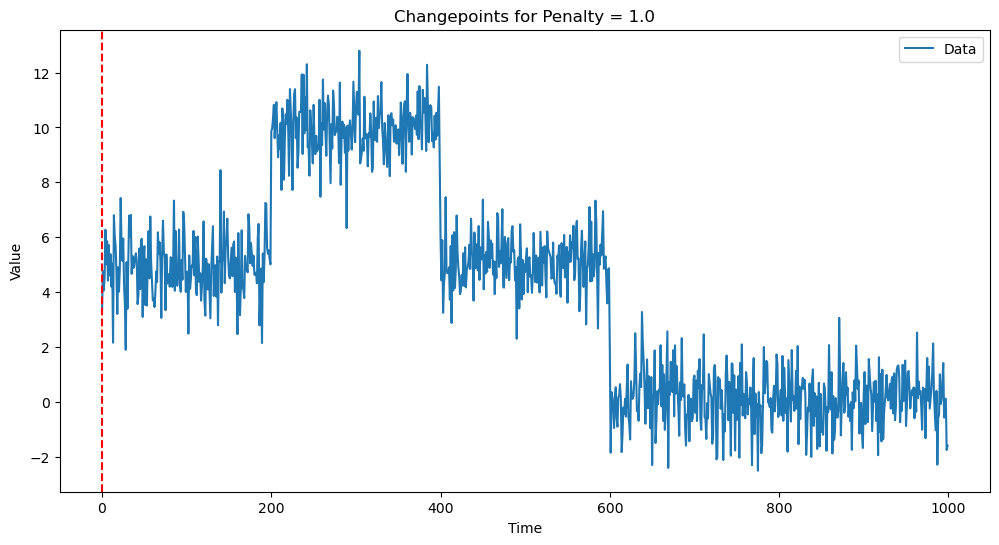

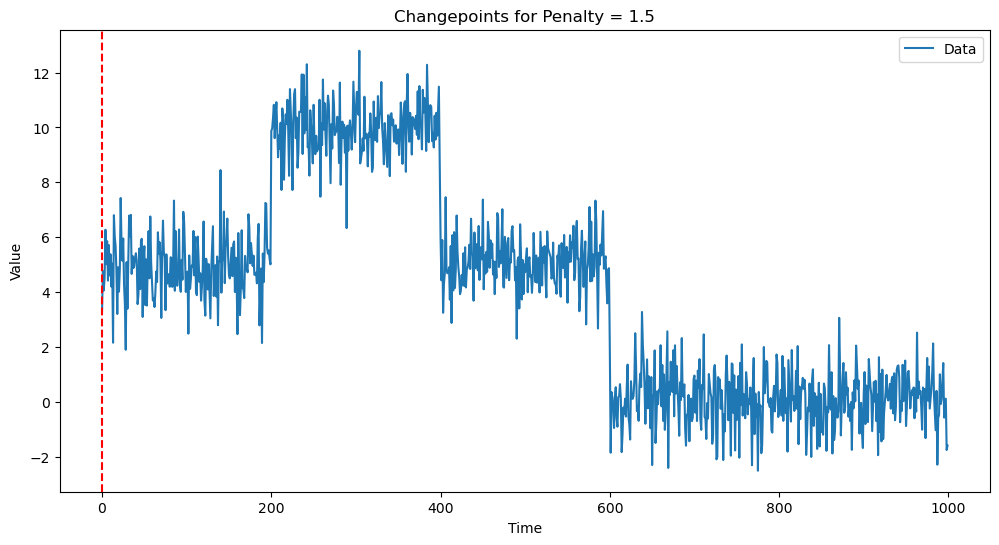

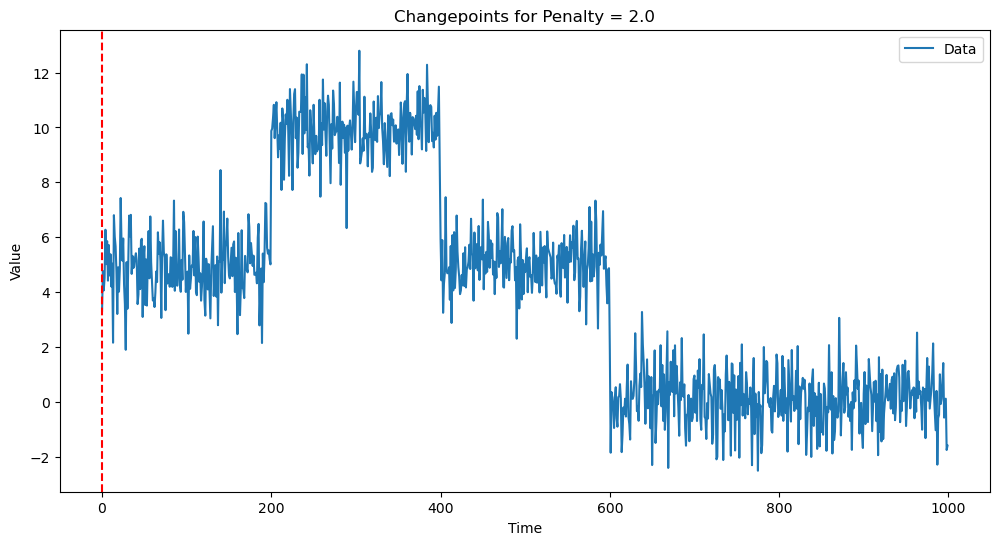

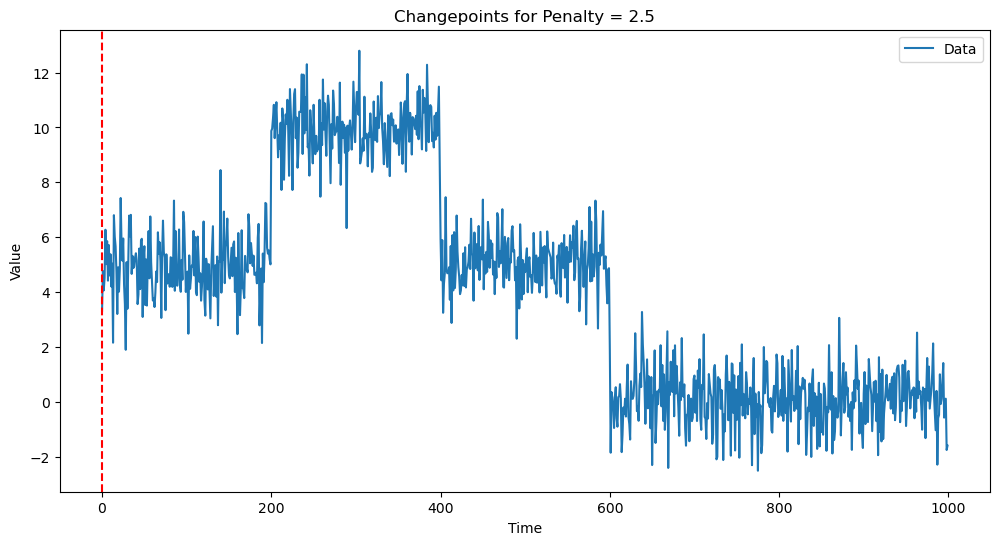

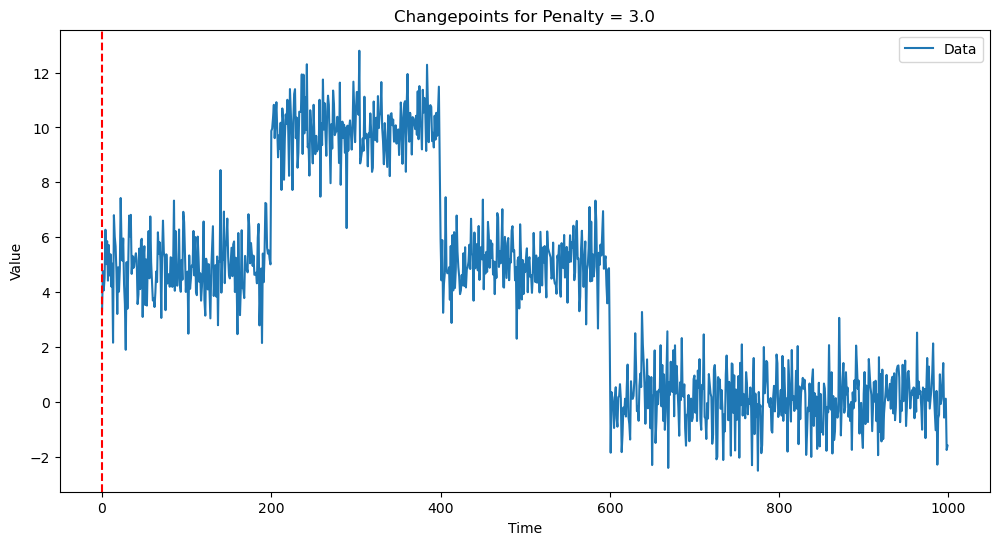

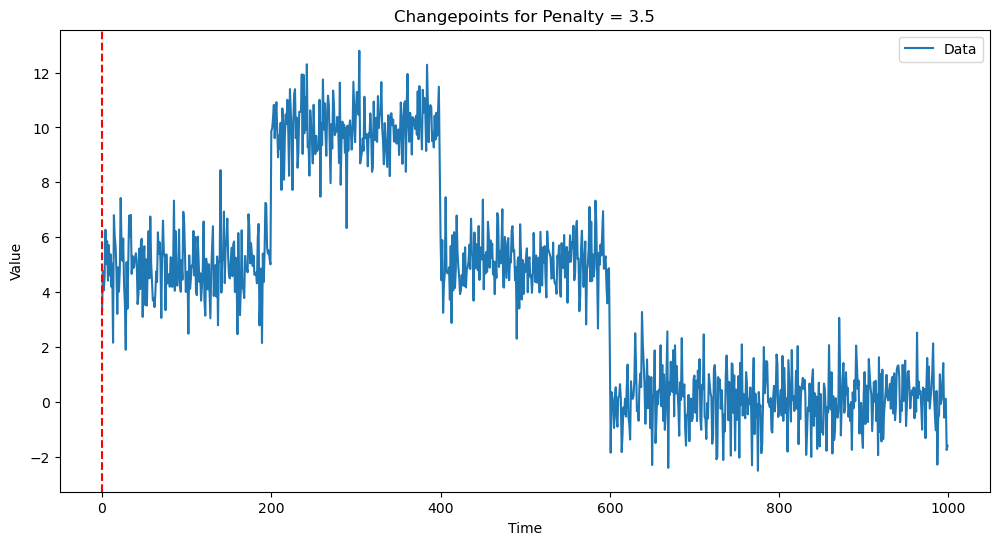

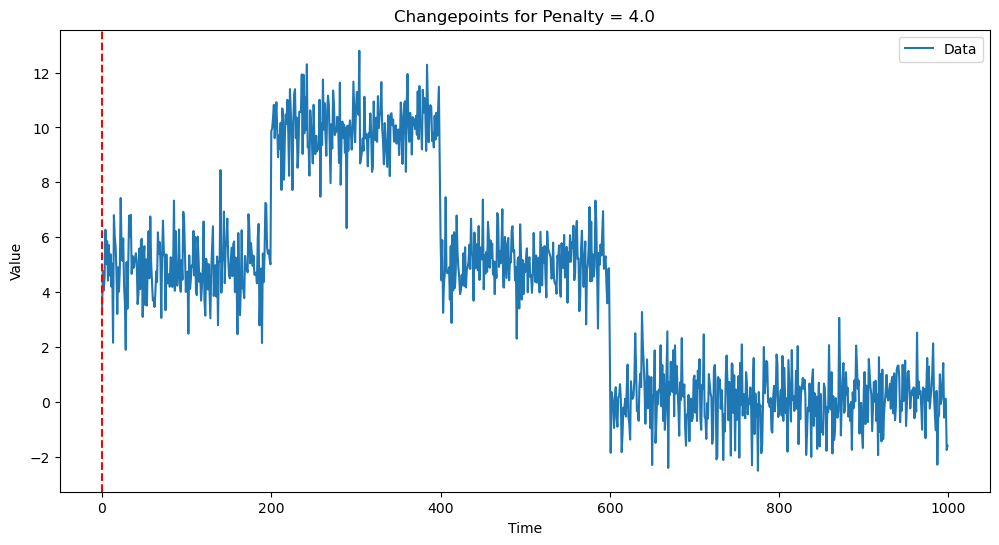

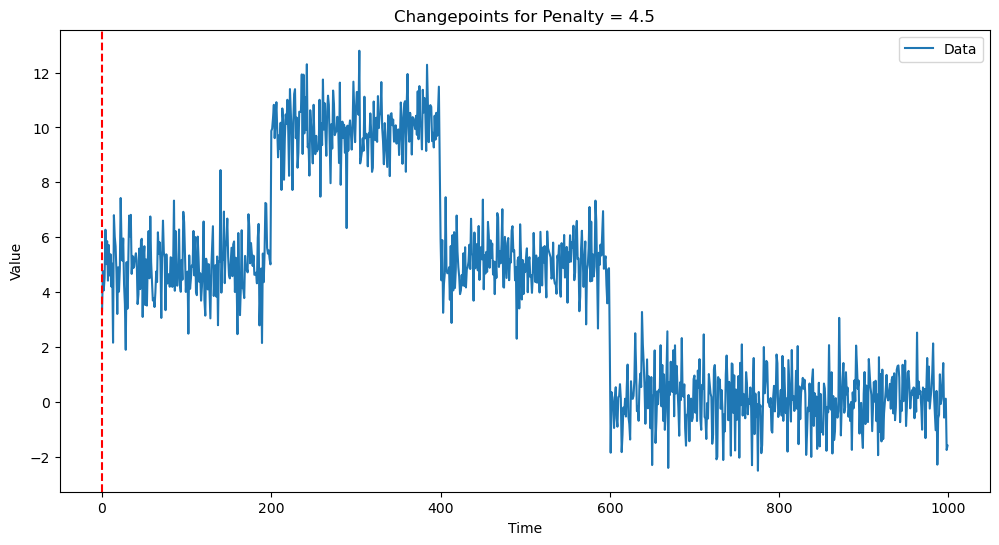

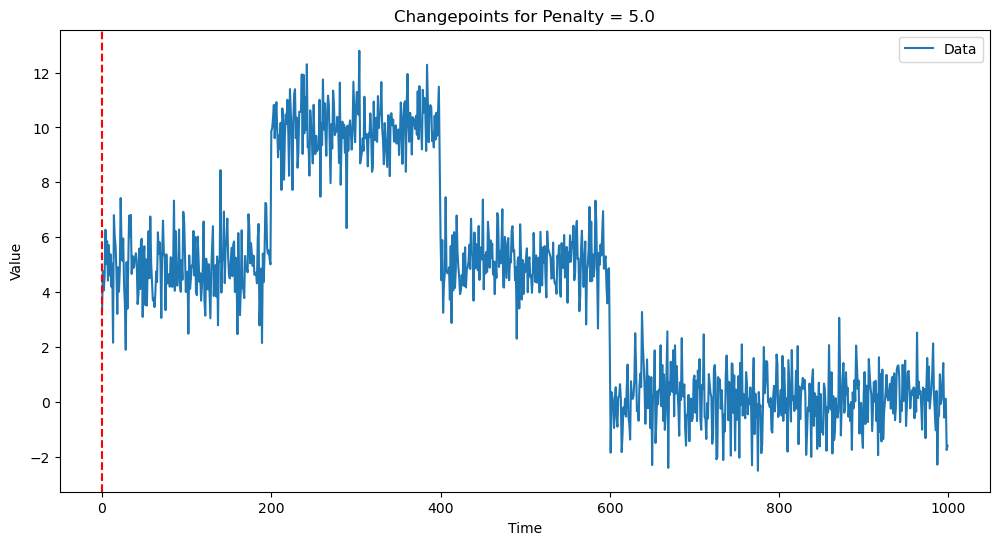

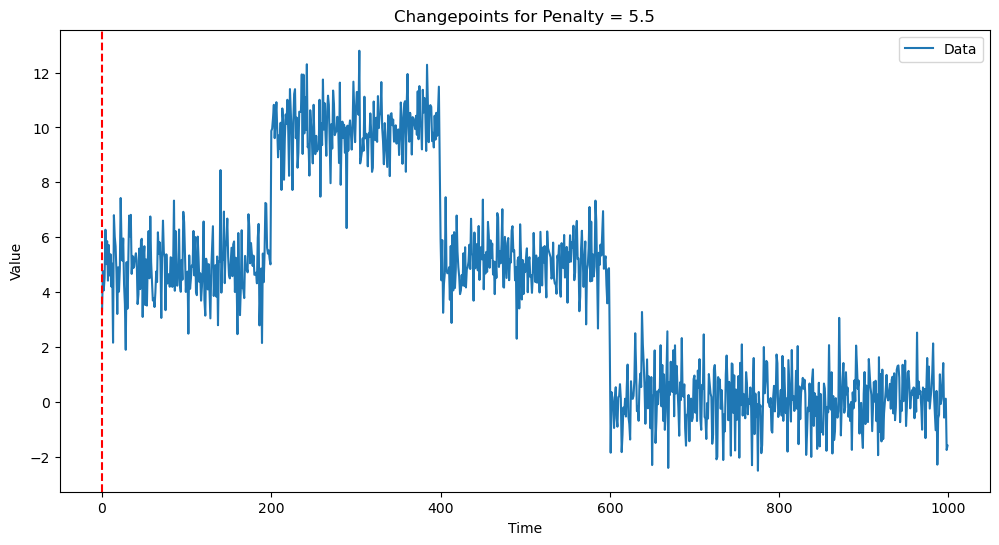

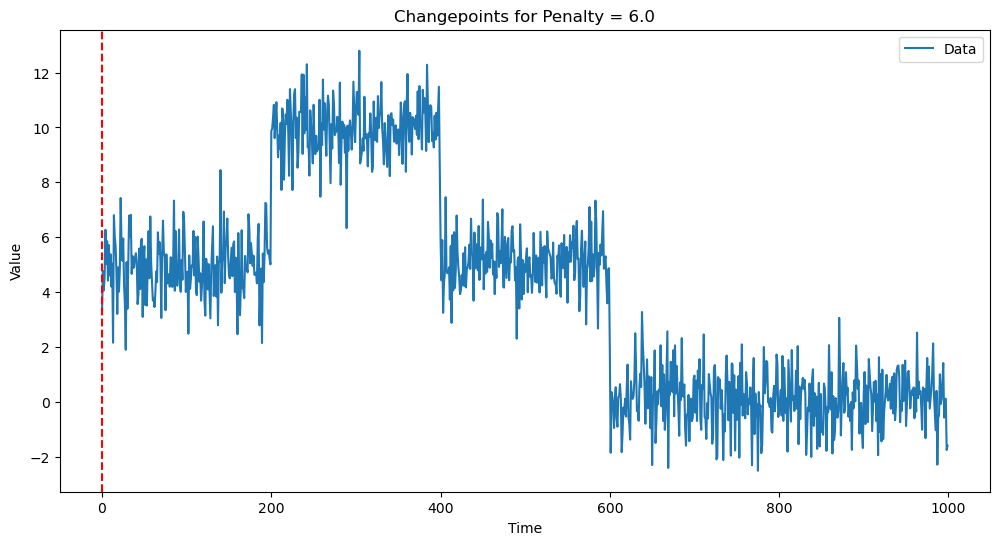

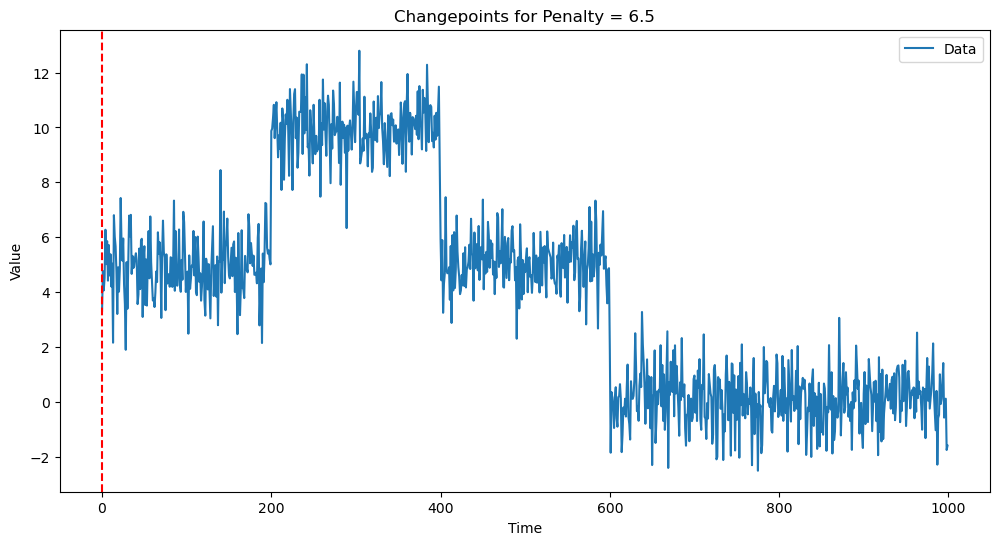

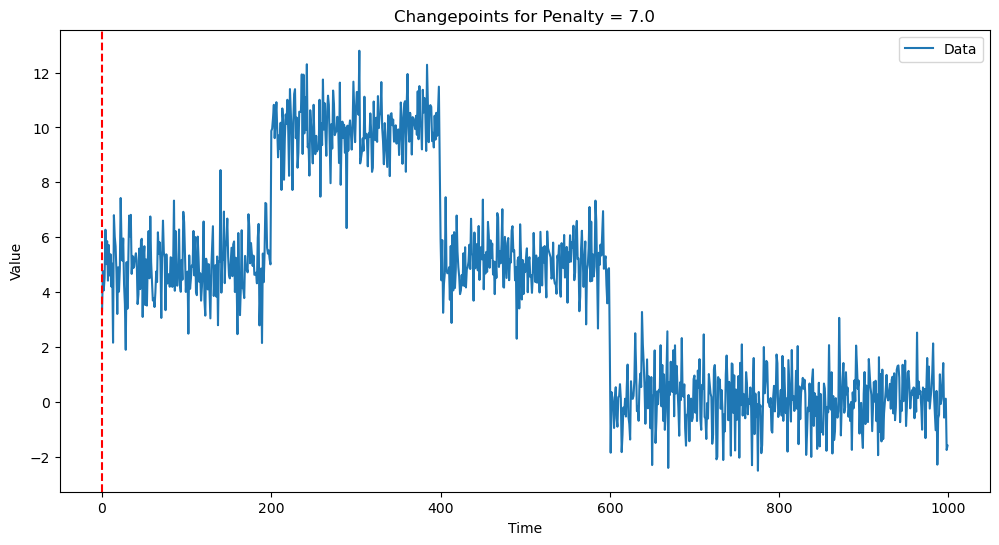

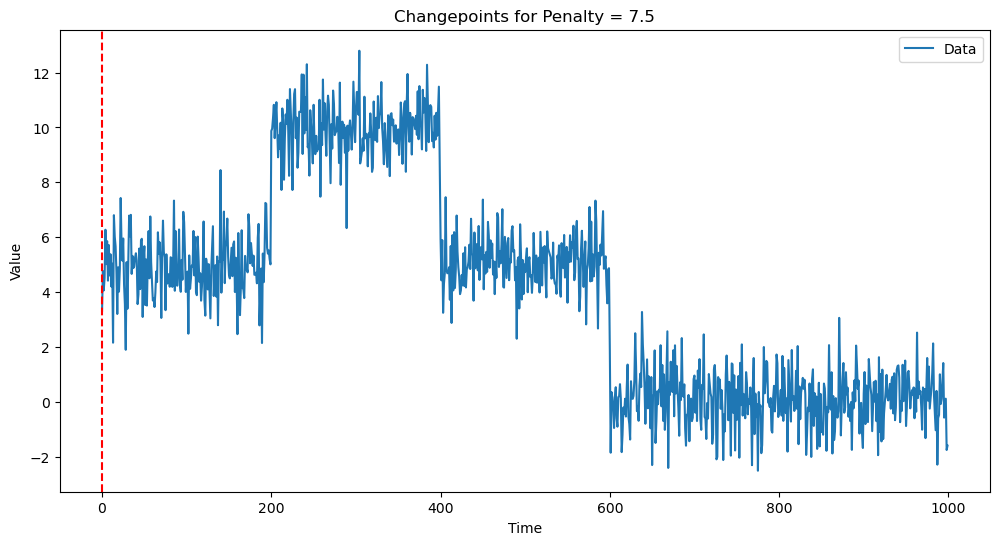

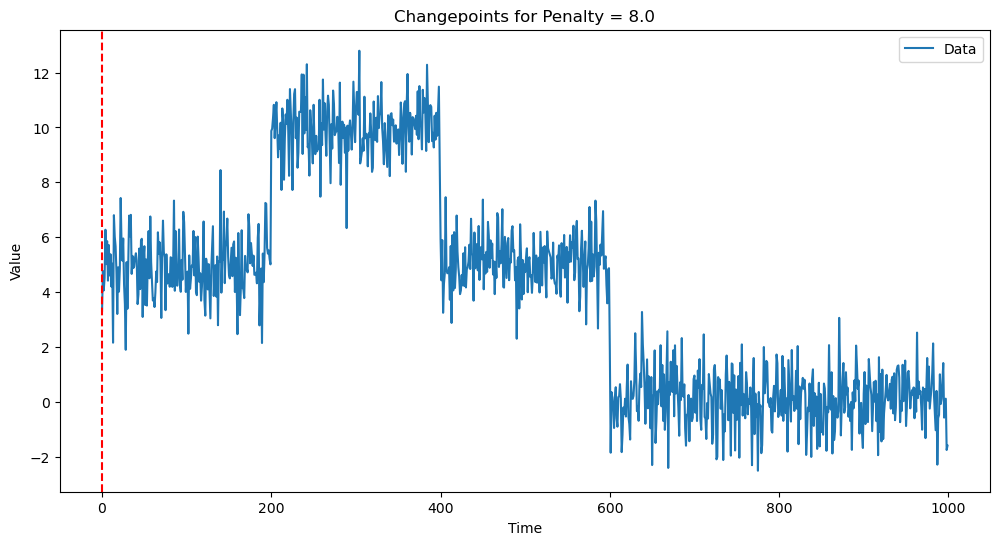

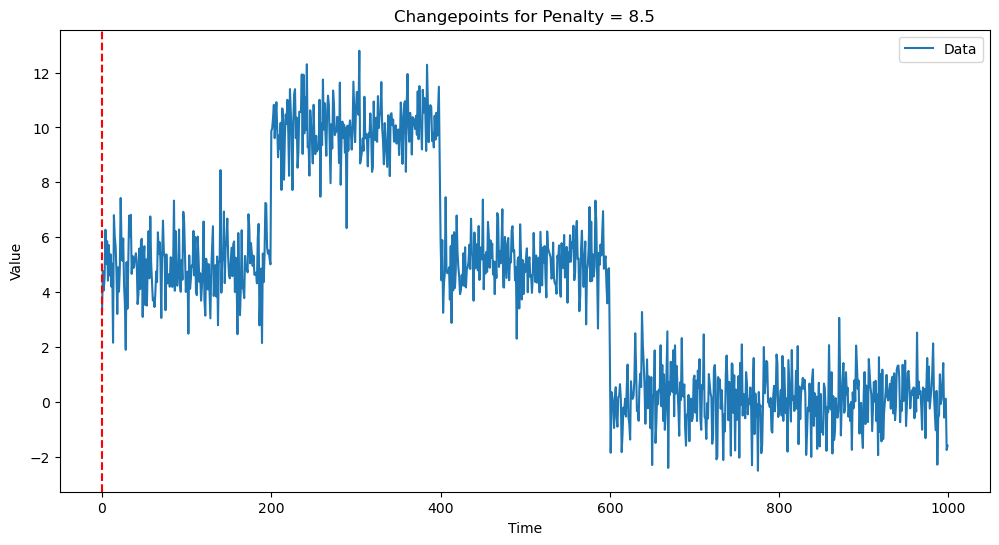

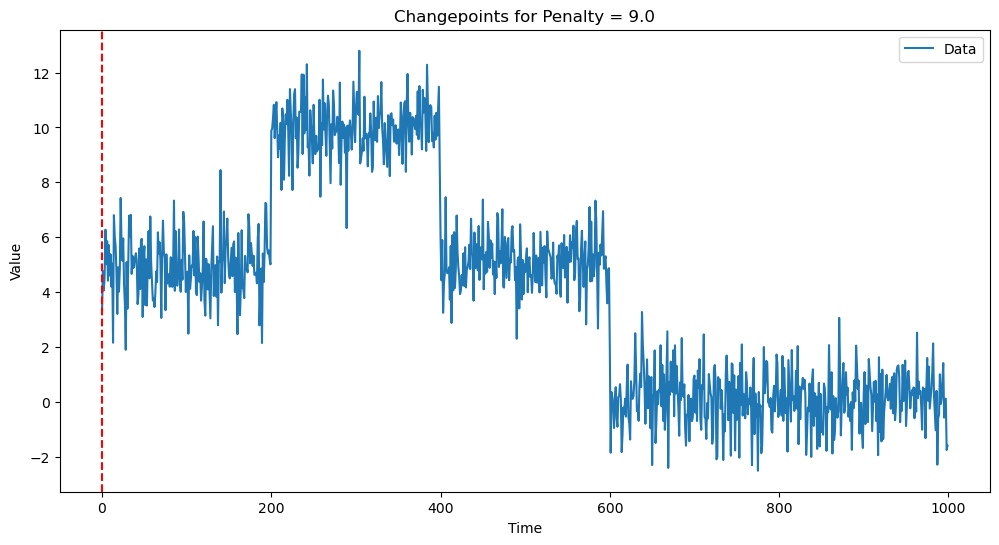

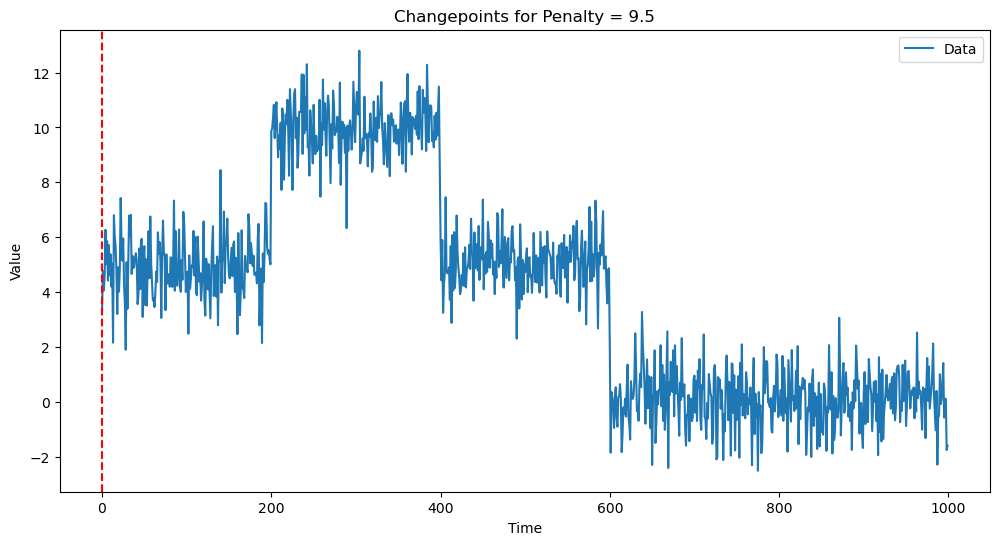

In [42]:
for penalty, changepoints in all_changepoints.items():
    title = f"Changepoints for Penalty = {penalty}"
    visualize_changepoints(data, changepoints, title=title)


In [35]:
segment = data[0:200]
print(penalized_cost(segment))

304.17314456497587


In [38]:
mock_candidates = [0, 50, 100, 150]
mock_costs = [0, 10, 5, 20]
t = 200
print(pruning_strategy(mock_candidates, mock_costs, t, data, penalty_factor=5))


[150]


3. Dynamic Programming for Segmentation (PELT Algorithm)
Initialize Variables: Set up variables to keep track of the segmentation and costs.
Dynamic Programming Loop: Iterate through the data, applying the Pruned Exact Linear Time (PELT) algorithm to find the optimal segmentation.
Pruning Strategy: Implement the pruning strategy to maintain computational efficiency.

4. Changepoints Over a Range of Penalties (CROPS Method)
Range of Penalties: Define a continuous range of penalty values.
Apply PELT with CROPS: Apply the PELT algorithm over the range of penalties, storing all optimal segmentations.

5. Analysis and Visualization
Analyze Results: Evaluate the detected changepoints, comparing different penalty values if necessary.
Visualize Changepoints: Create plots to visualize the detected changepoints and segmentations.

6. Application to Real-world Data
Load Real-world Data: For example, heart rate data during physical activity.
Apply Method: Use the implemented method to detect changepoints in the real-world data.
Interpret Results: Provide insights into the detected changepoints and their implications.

7. Testing and Validation
Create Test Cases: Develop test cases to validate each component of the implementation.
Benchmarking: Compare the implementation with existing methods or libraries, if available.